# GEOS-CF in Google Earth Engine


This notebook details methods for interacting with GEOS Composition Forecast (GEOS-CF) model diagnostics via the Google Earth Engine (GEE) Python API.

This API allows users to access a huge repository of data from GEE and use GEE functions to run fast server-side functions to manipulate data.

The strength of the GEE Python API is that users can pull data client-side and interact with selected fields within Pandas dataframes and other useful data structures.

This notebook will go through the following steps:

- Access GEOS-CF historical estimates and TROPOMI observations from the GEE data repository
- Turning an image collection into a Pandas dataframe at a selected point-of-interest
- Merging GEOS-CF model estimates of NO2 with TROPOMI observations of NO2
- Visualizing these data as images on an interactive folium map
- Visualizing these data using interactive plotly plots
- Gap-filling TROPOMI observations of tropospheric NO2 data with an XGBoost model


Notebook created by Callum Wayman, 2023

## Importing Required Modules

The Python Earth Engine API requires installation, authentican, and initialization in order to run in a Python environment. These steps can be accomplished in command line, or within Python code. 

More information on these steps can be found [here.](https://developers.google.com/earth-engine/guides/python_install)

Other modules required for this tutorial are listed below.

In [1]:
import ee

#ee.Authenticate()

ee.Initialize()

In [2]:
import datetime as dt
from math import sqrt
import requests

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## Importing Data from Google Earth Engine

Two collections are imported in this tutorial. The GEOS-CF time-averaged hourly replay collection is being imported, and more information on this collection can be found [here.](https://developers.google.com/earth-engine/datasets/catalog/NASA_GEOS-CF_v1_rpl_tavg1hr)

The other collection being imported is the Near Real-Time Nitrogen Dioxide image collection from the TROPOMI instrument. This collection offers observations of various atmospheric conditions and parameters, including NO2, which will be the focus of this tutorial.

In [3]:
# Import Data

# GEE Data
geosCf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr")
tropomi = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")

## Turning Earth Engine Objects into Pandas Dataframes

Google Earth Engine data is often presented in two object types: features and images.

Features and images may be stacked into feature collections and image collections.

These object types are extremely useful within GEE to manipulate large data sets quickly, however they offer some limitations in our ability to manipulate the data within when we use Python.

For this reason, this tutorial will geographically subset the imported image collections and transform them into Pandas dataframes. More information on Pandas dataframes can be found [here.](https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/frame.html)

In [4]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')
        
    # Convert the time field into a datetime.
    # Time values are stored differently for TROPOMI and GEOS-CF data
    # Need to remove the time columns from GEOS-CF dataframes
    if 'number' in list_of_bands[0]:
        df['datetime'] = pd.to_datetime(df['time'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
    else:
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        # Remove time columns from GEOS-CF dataframes
        df.pop('time')

    # Keep the columns of interest.
    df = df[['datetime',  *list_of_bands]]

    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    
    return df

In [5]:
class ee_subset:
    """
    A class with methods to create subsets of Earth Engine
    image collections.
      
    ...

    Attributes
    ----------
    band_dict : dict
        dictionary whose keys are band names and values are unit
        conversion values
    num_days : int
        number of days to be subset

    Methods
    -------
    get_subset_collection
        Returns a GEE collection subset for the number of days
        specified.
    get_point_df
        Takes a GEE image collection and returns a dataframe subset for the 
        number of days at a specific set of coordinates.
    """
    def __init__(self, band_dict, num_days):
        # Save band names and unit conversion values
        self.band_dict = band_dict
        self.band_list = list(band_dict.keys())
        
        # Get Dates
        # All subsets end at June 15th, 2023 for this tutorial
        f_date_datetime = dt.datetime.strptime('2023-06-15', "%Y-%m-%d")
        f_year = f_date_datetime.year
        f_month = f_date_datetime.month
        f_day = f_date_datetime.day
        i_date_datetime = f_date_datetime - dt.timedelta(num_days)
        i_year = i_date_datetime.year
        i_month = i_date_datetime.month
        i_day = i_date_datetime.day

        # Initial date of interest (inclusive).
        self.i_date = f'{i_year}-{i_month}-{i_day}'

        # Final date of interest (exclusive).
        self.f_date = f'{f_year}-{f_month}-{f_day}'
    
    def get_subset_collection(self, collection):
        """
        Subsets a GEE collection and returns subset 
        with appropriate time-window and bands selected.
        
        Parameters
        ----------
        collection : ee.imagecollection.ImageCollection
            GEE image collection to be subset
        

        Returns
        -------
        coll_subset : ee.imagecollection.ImageCollection
            Subset of collection
        """

        # Select bands and dates for collection
        coll_subset = collection.select(self.band_list).filterDate(self.i_date, self.f_date)

        return coll_subset
        
    
    def get_point_df(self, collection, lat, lon):
        """
        Subsets a GEE collection and returns subset 
        dataframe for a specific set of coordinates.
        
        Parameters
        ----------
        collection : ee.imagecollection.ImageCollection
            GEE image collection to be subset
        lat : int
            Latitude coordinate for point of interest
        lon : int
            Longitude coordinate for point of interest
        

        Returns
        -------
        data_features: pandas.core.frame.DataFrame
            Subset of collection returned as data frame
            for selected bands, time window, and point of interest.
        """
        
        # Get subsetted collection
        coll_subset = self.get_subset_collection(collection)
        
        # EE point from lat, lon
        poi = ee.Geometry.Point(lon, lat)
        
        # Scale in meters
        scale = 1000
        
        # Get the data for the pixel intersecting the point
        data_poi = coll_subset.getRegion(poi, scale).getInfo()
        
        # Call function to turn data into dataframe
        data_features = ee_array_to_df(data_poi, self.band_list)
        
        # Convert feature units to desired units for each band
        for b in self.band_list:
            data_features[b] = data_features[b]*self.band_dict[b]

        return data_features

## Subsetting GEE Data

Select the desired bands you wish to analyze from each collection. In this tutorial, we will be working with tropospheric column and surface level NO2 data.

We select relevant CF and TROPOMI bands, lat/lon, and number of days and subset the data using the ee_subset class and associated methods.

In [43]:
# Set selected bands
cfSurfBand = 'NO2' # mol mol-1
cfTropBand = 'TROPCOL_NO2' # 1.0e15 molec cm-2
tropNo2Band = 'tropospheric_NO2_column_number_density' # mol/m2

# Create band dictionaries to store unit conversion information
cf_chm_band_dict = {cfSurfBand: 1.0e9, cfTropBand: 10000*1e15/6.02e23, 'O3': 1.0e9, 'NOy': 1.0e9, 'PM25_RH35_GCC': 1}
cf_met_band_dict = {'T10M': 1, 'ZPBL': 1, 'U10M': 1, 'V10M': 1, 'RH': 1}
trop_band_dict = {tropNo2Band: 1}

# Change to exact lat/lon for takoma rec
lat = 38.97
lon = -77.02

# EE point from lat, lon
poi = ee.Geometry.Point(lon, lat)

#Number of days to visualize
num_days = 300

# Get subset GEE collection and subset Dataframe

# GEOS-CF Chemistry
cf_chm_subset = ee_subset(cf_chm_band_dict, num_days)
cf_chm_subset_collection = cf_chm_subset.get_subset_collection(geosCf)
cf_chm_features = cf_chm_subset.get_point_df(geosCf, lat, lon)

# GEOOS-CF Meteorology
cf_met_subset = ee_subset(cf_met_band_dict, num_days)
cf_met_subset_collection = cf_met_subset.get_subset_collection(geosCf)
cf_met_features = cf_met_subset.get_point_df(geosCf, lat, lon)

# TROPOMI chemistry
trop_subset = ee_subset(trop_band_dict, num_days)
trop_subset_collection = trop_subset.get_subset_collection(tropomi)
trop_features = trop_subset.get_point_df(tropomi, lat, lon)

## Mapping GEOS-CF and TROPOMI

Using the folium package, we can create leaflet maps that allow us to view the data we have accessed from the GEE data repository.

This section will also explore the use of plotly plots to show a time-series of the subsetted data from GEOS-CF and TROPOMI at the point of interest.

In [7]:
# Define a point of interest (POI) with a buffer zone of 1000 km around POI.
roi = poi.buffer(1e6)

# Reduce the LST collection by mean.
cf_img = cf_chm_subset_collection.mean()

# Adjust for scale factor.
cf_img = cf_img.select(cfSurfBand).multiply(cf_chm_band_dict[cfSurfBand])

my_map = folium.Map(location=[lat, lon], zoom_start=10)

### Adding a Useful Folium Method

The below function creates a new folium method and adds it to the folium.Map class.

This function receives an Earth Engine image object and creates a set of folium tiles from that image which can be added to the map.

The new method allows us to easily visualize images on a basemap as we might in the GEE code editor.

In [8]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adds a method for displaying Earth Engine image tiles to folium map.
    
    Parameters
        ----------
        ee_image_object : ee.image.Image
            GEE image collection to be subset
        vis_params : dict
            Dictionary of GEE visualization parameters
        
        Returns
        -------
        None
    """
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)
    
# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

### Creating an Interactive Time-Series Plot

In this section, we create and save a plotly plot showing a time-series of tropospheric NO2 data from GEOS-CF and TROPOMI.

The interactive plot will be added to a below folium map.

In [9]:
# Make the figure object
fig=make_subplots(specs=[[{"secondary_y":True}]])

# Create the first plotly trace showing GEOS-CF tropospheric NO2
fig.add_trace(
    go.Scatter(
    x=cf_chm_features['datetime'],
    y=cf_chm_features[cfTropBand],
    name="Tropospheric NO2 (mol/m^2)",
    mode='lines+markers',
    hoverinfo='y',
    line = dict(color='indigo', width=3)
     ),
    secondary_y=False)

# Create the second plotly trace showing TROPOMI tropospheric NO2
fig.add_trace(
    go.Scatter(
    x=trop_features['datetime'],
    y=trop_features[tropNo2Band],
    name="TROPOMI NO2 (mol/m^2)",
    mode='markers',
    hoverinfo='y',
    line = dict(color='red', width=3)
     ),
    secondary_y=False)

# Update figure axis aesthetics and labels
fig.update_layout(hoverlabel_bgcolor='#DAEEED',  #Change the background color of the tooltip to light gray
             title_text="GEOS-CF Tropospheric NO2 Replay", #Add a chart title
             title_font_family="Times New Roman",
             title_font_size = 20,
             title_font_color="darkblue", #Specify font color of the title
             title_x=0.5, #Specify the title position
             xaxis=dict(
                    tickfont_size=10,
                    tickangle = 270,
                    showgrid = True,
                    zeroline = True,
                    showline = True,
                    showticklabels = True,
                    #dtick=86400000,
                    dtick="M1",
                    tickformat="%m/%d\n%Y"
                    ),
             legend = dict(orientation = 'h', xanchor = "center", x = 0.72, y= 1), #Adjust legend position
             yaxis_title='Tropospheric NO2 (mol/m^2)')

# Set scientific notation format for y-axis
fig.update_yaxes(exponentformat='e')

# Write the image to a local html file
fig.write_html('surface_no2.html')

In [149]:
# Select tropospheric NO2 and date range for GEOS-CF and scale to ppbv
cf_trop_img = cf_chm_subset_collection.select(cfTropBand).filterDate('2023-05-14', '2023-05-15').mean().multiply(cf_chm_band_dict[cfTropBand])

# Select tropospheric NO2 and date range for TROPOMI
trop_img = trop_subset_collection.filterDate('2023-05-14', '2023-05-15').mean()

# Set visualization parameters for NO2
cf_vis_params = {
    'min': 1,'max': 40,
    'palette': ['white', 'purple'],
    'opacity': 0.5
}

# Visualization parameters for tropospheric column NO2
visTrop = {'min': 1e-6,
    'max': 1e-4,
    'palette': ['white', 'purple'],
    'opacity': 0.7
          }

# Create a map.
lat, lon = lat, lon
my_map = folium.Map(location=[lat, lon], zoom_start=10)

# Add the cf and tropomi data to the map object.
my_map.add_ee_layer(cf_trop_img, visTrop, 'GEOS-CF NO2')
my_map.add_ee_layer(trop_img, visTrop, 'TROPOMI NO2')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Set the plotly-generated html file into a html snippet
html="""
    <iframe src=\"""" + 'surface_no2.html' + """\" width="850" height="400"  frameborder="0">    
    """
    
# Create pop-up with added plotly html snippet
popup = folium.Popup(folium.Html(html, script=True))

# Add marker to map for point of interest
marker = folium.Marker([lat, lon],
                       popup=popup).add_to(my_map)

# Display the map.
display(my_map)

## Notes

Consider a 3-hour CF window around tropomi overpass time instead of 1 to 1 correspondance.

Go back to old forecasts, how well did forecasts predict what tropomi would look like? 1 day out? 5 days out?

overfitting check can be the mean bias in training vs testing

talk to viral about interesting pandora sites
- greenbelt site?

target tropospheric column and then derive to surface and compare to openaq

use xgboost model to predict difference between model and obs

## XGBoost Model

In this section, we will use an XGBoost model to gap-fill TROPOMI observations of tropospheric column NO2.

This gap-filled data set can then be use to create an estimate of surface level NO2 values derived from observations.

In [103]:
# merge chemistry and met features
features = cf_chm_features.merge(cf_met_features,on='datetime')

In [104]:
features

,datetime,NO2,TROPCOL_NO2,O3,NOy,PM25_RH35_GCC,T10M,ZPBL,U10M,V10M,RH
0,2022-08-19 00:00:00,39.115548,0.000344,33.120159,43.773138,20.976545,299.431396,101.675491,0.987069,-0.009957,0.401069
1,2022-08-19 01:00:00,51.630195,0.000377,19.354047,57.859360,26.945976,298.837646,89.055984,0.870566,0.632004,0.430046
2,2022-08-19 02:00:00,57.858415,0.000391,11.088559,66.241270,32.284721,297.836121,93.055466,0.915228,1.047089,0.468854
3,2022-08-19 03:00:00,58.440492,0.000379,7.989002,69.268076,36.021759,297.025543,96.043411,1.109106,1.233765,0.516178
4,2022-08-19 04:00:00,54.715201,0.000348,7.887162,67.289001,37.341030,296.371277,94.409607,1.308153,1.157421,0.561617
...,...,...,...,...,...,...,...,...,...,...,...
7195,2023-06-14 19:00:00,2.073674,0.000067,54.482371,5.007529,19.208469,301.013977,2895.714111,8.119921,0.211730,0.343045
7196,2023-06-14 20:00:00,2.317420,0.000076,56.868885,5.320395,16.458733,300.827728,2903.690186,8.084328,-0.352637,0.337592
7197,2023-06-14 21:00:00,2.943152,0.000095,57.916623,6.026161,15.506337,300.375580,2887.675537,7.734241,-1.326032,0.333087
7198,2023-06-14 22:00:00,4.678468,0.000132,54.773409,7.641396,16.332447,299.305786,2687.665283,6.853080,-2.368311,0.335393


In [105]:
samp = features.resample('3H', on='datetime').mean()
samp.reset_index(inplace=True)

In [106]:
# target variable is observation in ppbv
target = trop_features.copy()
target['datetime'] = pd.to_datetime(target['datetime'])
target["datetime"] = target["datetime"].dt.round("H")
#target.pop('time')
target

,datetime,tropospheric_NO2_column_number_density
0,2022-08-20 18:00:00,0.000055
1,2022-08-20 18:00:00,0.000054
2,2022-08-22 18:00:00,0.000054
3,2022-08-23 19:00:00,0.000019
4,2022-08-24 19:00:00,0.000031
...,...,...
207,2023-06-05 18:00:00,0.000046
208,2023-06-07 19:00:00,0.000042
209,2023-06-08 19:00:00,0.000054
210,2023-06-10 18:00:00,0.000043


In [109]:
#features=samp

#print(features, target)

# also add target observation
#merged = features.merge(target,on='datetime', how='left')
merged = features.merge(target, on='datetime', how='right')
#merged = pd.merge_asof(features, target, on='datetime', direction='nearest')
merged.fillna(value=np.nan, inplace=True)
#merged.resample('3H', on='datetime').mean()
#merged.reset_index(inplace=True)
#merged.pop('index')
merged

,datetime,NO2,TROPCOL_NO2,O3,NOy,PM25_RH35_GCC,T10M,ZPBL,U10M,V10M,RH,tropospheric_NO2_column_number_density
0,2022-08-20 18:00:00,2.302841,0.000077,69.499947,7.007527,10.794555,305.160095,2071.192139,-2.183990,3.047747,0.383022,0.000055
1,2022-08-20 18:00:00,2.302841,0.000077,69.499947,7.007527,10.794555,305.160095,2071.192139,-2.183990,3.047747,0.383022,0.000054
2,2022-08-22 18:00:00,3.841706,0.000117,81.257895,10.231198,15.998955,303.325409,1481.112549,0.690596,2.178982,0.542759,0.000054
3,2022-08-23 19:00:00,2.844900,0.000089,70.314854,6.440954,9.640683,304.516907,2278.976318,4.459662,-2.014236,0.375797,0.000019
4,2022-08-24 19:00:00,3.336027,0.000126,77.183358,8.965196,14.720308,304.889404,2471.236816,2.121656,-1.549100,0.359143,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...
207,2023-06-05 18:00:00,2.557505,0.000100,52.503310,5.865779,9.029044,299.358032,2458.927490,1.636331,-3.444071,0.316794,0.000046
208,2023-06-07 19:00:00,3.135954,0.000129,57.974830,7.429632,19.317167,299.272949,2963.072266,2.887377,-1.826380,0.243825,0.000042
209,2023-06-08 19:00:00,3.390613,0.000166,52.852556,7.960626,45.308933,298.648254,3311.685303,1.412741,-2.656273,0.250979,0.000054
210,2023-06-10 18:00:00,2.281037,0.000090,59.022568,6.404037,24.551970,302.228943,2763.504883,3.934820,-0.538879,0.256635,0.000043


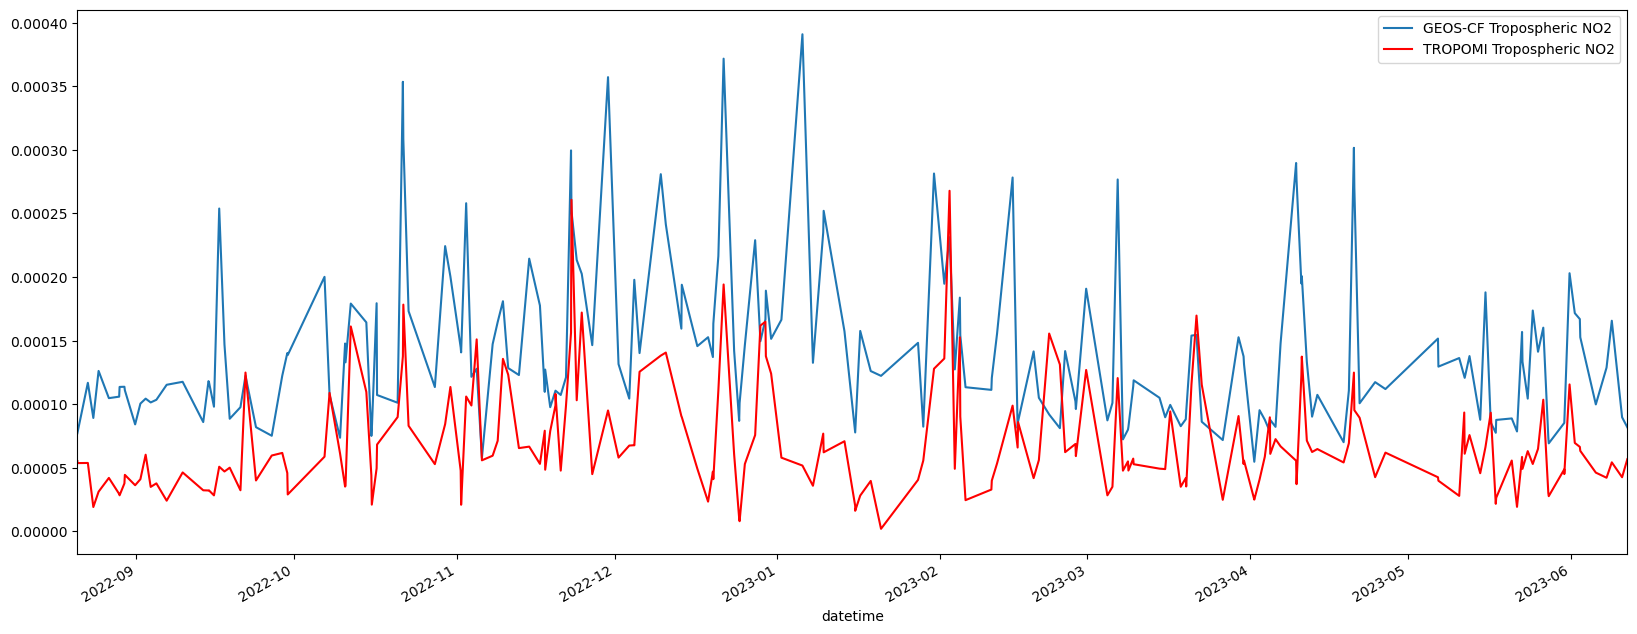

In [110]:
fig, ax = plt.subplots(figsize=(20, 8))
merged.plot(x = 'datetime', y = cfTropBand, ax = ax, label = 'GEOS-CF Tropospheric NO2') 
merged.plot(x = 'datetime', y = tropNo2Band, ax = ax, c = 'r', label = 'TROPOMI Tropospheric NO2', zorder=2)
ax.set_xlim([merged.datetime.min(), merged.datetime.max()])
ax.legend()
plt.show()

In [111]:
type(merged[[tropNo2Band]])

pandas.core.frame.DataFrame

In [112]:
merged.shape

(212, 12)

In [113]:
chm_vars = list(cf_chm_band_dict.keys())
chm_vars

['NO2', 'TROPCOL_NO2', 'O3', 'NOy', 'PM25_RH35_GCC']

In [114]:
met_vars = list(cf_met_band_dict.keys())
met_vars

['T10M', 'ZPBL', 'U10M', 'V10M', 'RH']

In [115]:
# Training from Christoph's code
# create X and Y for XGBoost
X = merged[chm_vars+met_vars]
Y = merged[[tropNo2Band]] * 10000

X_arr = X.to_numpy()
Y_arr = Y.to_numpy()[:,0]

print(X_arr.shape, Y_arr.shape)

X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.nan)

#print(X, Y)

# train model
print('BEGIN TRAINING')
train = xgb.DMatrix(X,Y)
param = {'booster' : 'gbtree', 'eta': 0.3, 'verbosity': 2}
model = xgb.train(param,dtrain)
train_pred = model.predict(dtrain)
prediction = model.predict(dtest)

(212, 10) (212,)
(169, 10) (43, 10)
BEGIN TRAINING
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[10:45:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost-spli

### Tuning the XGBoost Model Hyperparameters

In [116]:
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

from sklearn.metrics import mean_absolute_error

# Compute MAE
mae_baseline = mean_absolute_error(y_test, prediction)
mae_baseline

0.25823751128510414

In [117]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

params['eval_metric'] = "mae"

# Set a high number of boost rounds
# We hope to find optimal number of rounds before this
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[10:45:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-mae:0.28272
[10:45:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-mae:0.27291
[10:45:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-mae:0.26693
[10:45:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-mae:0.25865
[10:45:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-mae:0.25066
[10:45:25]

In [118]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 0.25 with 5 rounds


In [141]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=7
[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=7
[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=7
[10:58:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: 

In [123]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.234922,0.005816,0.263960,0.039816
1,0.183233,0.002910,0.244891,0.041316
2,0.145106,0.002433,0.237057,0.039515
3,0.116855,0.003526,0.233098,0.045926
4,0.094919,0.004369,0.227443,0.043865
5,0.077914,0.004265,0.222831,0.041524
6,0.065941,0.004488,0.221789,0.044464
7,0.056402,0.004726,0.220237,0.043559
8,0.047992,0.004741,0.220086,0.044146


In [124]:
cv_results['test-mae-mean'].min()

0.22008622087896823

In [126]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]
gridsearch_params

[(9, 5), (9, 6), (9, 7), (10, 5), (10, 6), (10, 7), (11, 5), (11, 6), (11, 7)]

In [147]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10,
        verbose_eval=0
    );    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min();
    boost_rounds = cv_results['test-mae-mean'].argmin();
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
        print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=7
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_167903509

[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=7
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=7
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[10:59:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: 

[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: 

[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:

[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=7
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98:

[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=7
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[10:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/tree/updater_prune.cc:9

In [150]:
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

Best params: 10, 6, MAE: 0.20499794797941964


r2 = 0.98
nrmse = 0.15
nmb = -0.02


(array([19327., 19358., 19389., 19417., 19448., 19478.]),
 [Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05')])

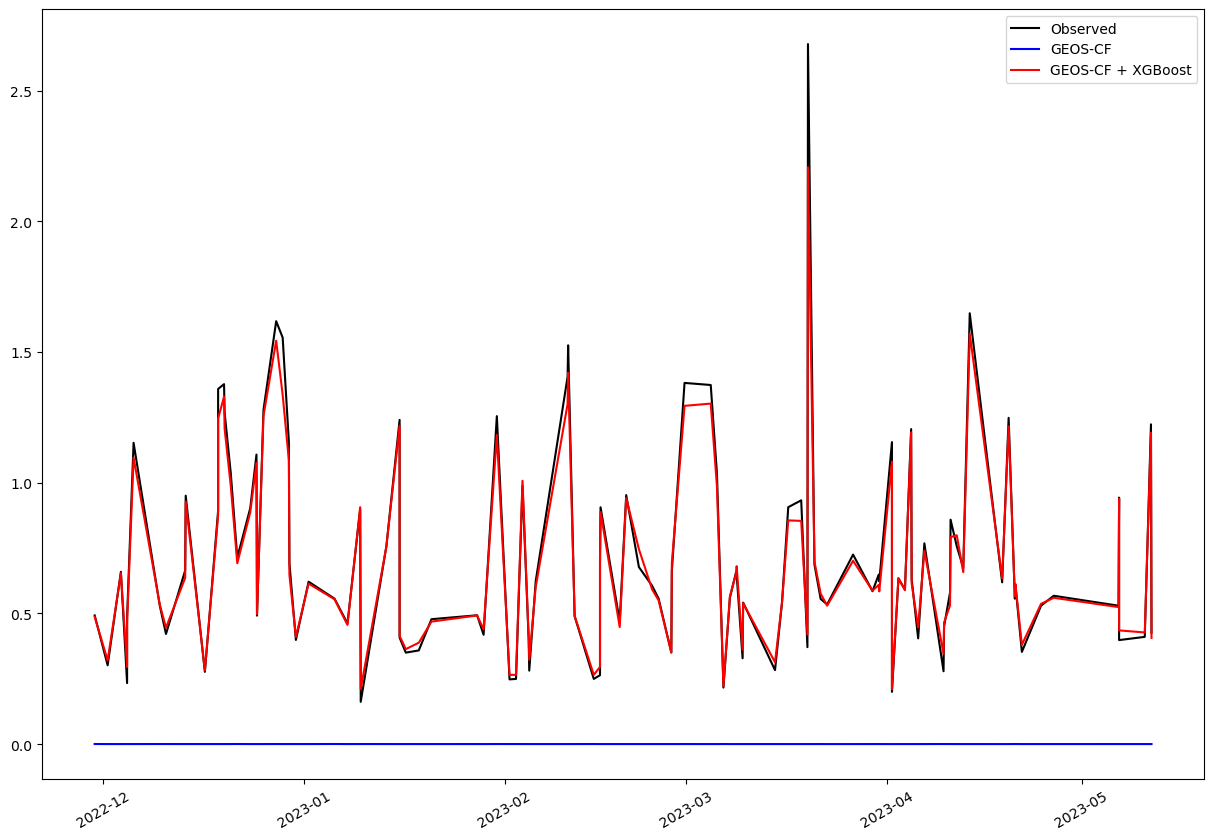

In [22]:
# statistics (on the trained data - this is cheating!)
yflat = np.array(y_train).ravel()
print('r2 = {:.2f}'.format(r2_score(yflat,train_pred)))
print('nrmse = {:.2f}'.format( sqrt(mean_squared_error(yflat,train_pred))/np.std(yflat)))
print('nmb = {:.2f}'.format(np.sum(train_pred-yflat)/np.sum(yflat)))

# plot
dat = pd.DataFrame({'obs':yflat,'pred':train_pred})
dat['date'] = merged['datetime']
dat['orig'] = merged[cfTropBand]

fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(dat['date'],dat['obs'],color='black',label='Observed')
ax.plot(dat['date'],dat['orig'],color='blue',label='GEOS-CF')
ax.plot(dat['date'],dat['pred'],color='red',label='GEOS-CF + XGBoost')
ax.legend()

plt.xticks(rotation=30)

r2 = 0.29
nrmse = 0.84
nmb = 0.07


(array([19325., 19327., 19331., 19335., 19339., 19343., 19347., 19351.,
        19355., 19358., 19362.]),
 [Text(19325.0, 0, '2022-11-29'),
  Text(19327.0, 0, '2022-12-01'),
  Text(19331.0, 0, '2022-12-05'),
  Text(19335.0, 0, '2022-12-09'),
  Text(19339.0, 0, '2022-12-13'),
  Text(19343.0, 0, '2022-12-17'),
  Text(19347.0, 0, '2022-12-21'),
  Text(19351.0, 0, '2022-12-25'),
  Text(19355.0, 0, '2022-12-29'),
  Text(19358.0, 0, '2023-01-01'),
  Text(19362.0, 0, '2023-01-05')])

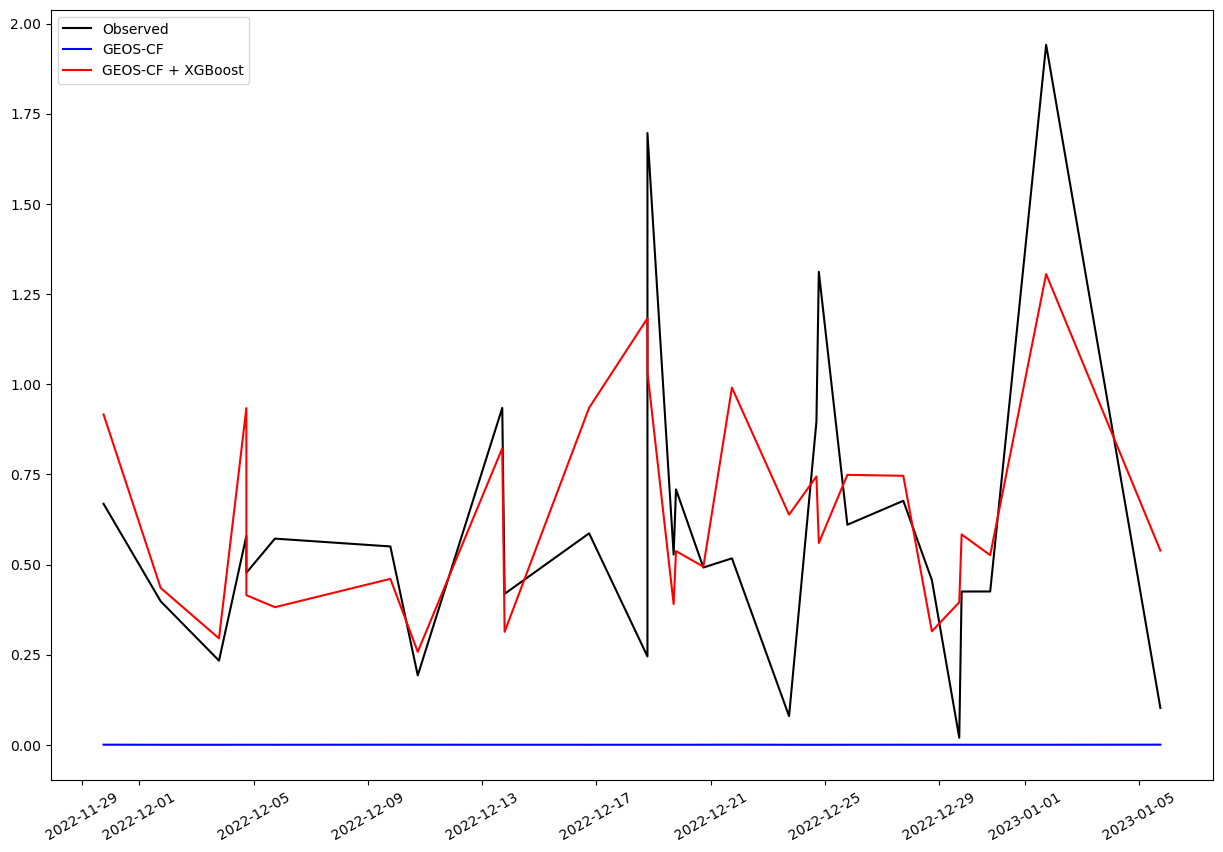

In [23]:
yflat = np.array(y_test).ravel()
print('r2 = {:.2f}'.format(r2_score(yflat,prediction)))
print('nrmse = {:.2f}'.format( sqrt(mean_squared_error(yflat,prediction))/np.std(yflat)))
print('nmb = {:.2f}'.format(np.sum(prediction-yflat)/np.sum(yflat)))

# plot
dat = pd.DataFrame({'obs':yflat,'pred':prediction})
dat['date'] = merged['datetime']
dat['orig'] = merged[cfTropBand]

fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(dat['date'],dat['obs'],color='black',label='Observed')
ax.plot(dat['date'],dat['orig'],color='blue',label='GEOS-CF')
ax.plot(dat['date'],dat['pred'],color='red',label='GEOS-CF + XGBoost')
ax.legend()

plt.xticks(rotation=30)

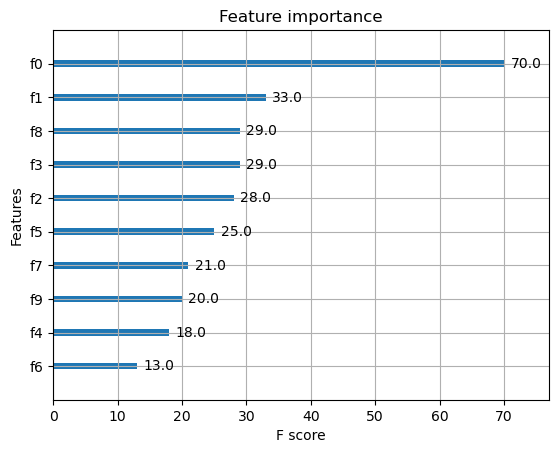

In [24]:
xgb.plot_importance(model)
plt.show()

In [25]:
# How to derive shapley values
# Need to load JS vis in the notebook
#import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 100
shap.force_plot(explainer.expected_value, shap_values[i], features=X.loc[i], feature_names=X.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


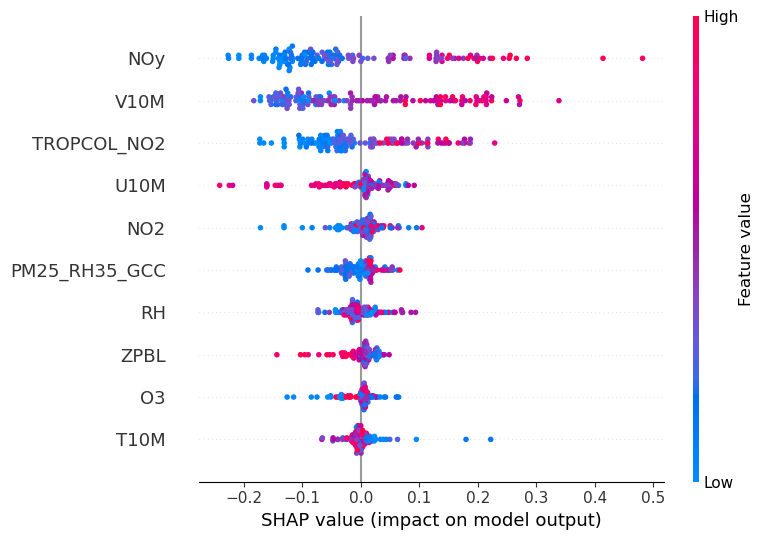

In [26]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

## Explaining the plot above

Interpretation is that a high value of a feature in red contributes to either higher or lower tropomi derived sfc no2. For example, high NO2 from GEOS-CF usually corresponds to a higher predicted sfc NO2, however higher ZPBL corresponds to a lower sfc NO2.

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. [...] SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.
(https://datascience.stackexchange.com/questions/99650/difference-between-feature-effect-and-feature-importance)

In other words, feature importance explains contribution to goodness of fit, and SHAP value explains contribution to predicted value.

In [48]:
# Apply predictor to full input dataset
data = features.copy()[chm_vars+met_vars]
dtest = xgb.DMatrix(data)
ypred = model.predict(dtest)

# Make a long merged dataset to produce a gap-filled prediction of tropomi derived sfc no2
merged_long = features.merge(target.drop_duplicates(subset=['datetime']),on='datetime', how='left')
merged_long.fillna(value=np.nan, inplace=True)
merged_long['preds'] = ypred / 10000
merged_long

,datetime,NO2,TROPCOL_NO2,O3,NOy,PM25_RH35_GCC,T10M,ZPBL,U10M,V10M,RH,tropospheric_NO2_column_number_density,preds
0,2022-11-27 00:00:00,30.559058,0.000199,7.137714,36.497159,19.573883,280.363342,178.446426,1.620176,2.902557,0.504786,NaN,0.000152
1,2022-11-27 01:00:00,25.786026,0.000171,11.525117,30.094281,19.073511,279.877075,164.422882,1.570828,2.827712,0.536407,NaN,0.000148
2,2022-11-27 02:00:00,22.933849,0.000152,14.260877,26.398073,19.105448,279.141724,166.642212,1.531623,2.895503,0.573025,NaN,0.000136
3,2022-11-27 03:00:00,21.187619,0.000142,15.483238,24.477286,19.575693,278.594116,165.148911,1.354471,2.945053,0.620879,NaN,0.000111
4,2022-11-27 04:00:00,20.983894,0.000142,14.857505,24.477339,20.701996,278.653748,155.217026,1.087648,2.811055,0.664392,NaN,0.000111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,2023-06-14 19:00:00,2.073674,0.000067,54.482371,5.007529,19.208469,301.013977,2895.714111,8.119921,0.211730,0.343045,NaN,0.000042
4796,2023-06-14 20:00:00,2.317420,0.000076,56.868885,5.320395,16.458733,300.827728,2903.690186,8.084328,-0.352637,0.337592,NaN,0.000037
4797,2023-06-14 21:00:00,2.943152,0.000095,57.916623,6.026161,15.506337,300.375580,2887.675537,7.734241,-1.326032,0.333087,NaN,0.000055
4798,2023-06-14 22:00:00,4.678468,0.000132,54.773409,7.641396,16.332447,299.305786,2687.665283,6.853080,-2.368311,0.335393,NaN,0.000039


### Creating Surface Data from TROPOMI Observations

In [28]:
def get_sfc(target):
    target['sfc'] = target[tropNo2Band] * cf_chm_features[cfSurfBand] / cf_chm_features[cfTropBand]
    
    return target

trop_features = get_sfc(trop_features)

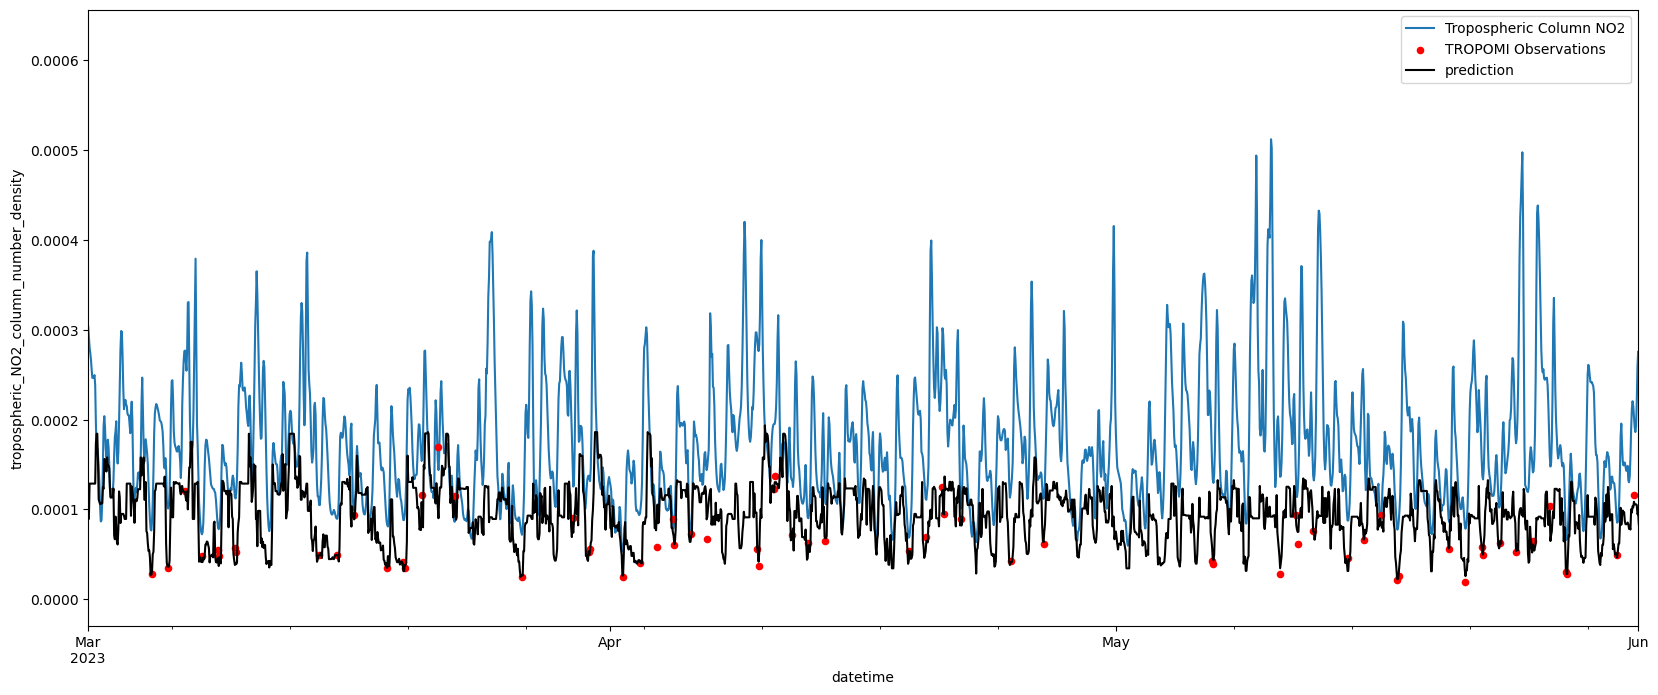

In [29]:
fig, ax = plt.subplots(figsize=(20, 8))
merged_long.plot(x = 'datetime', y = cfTropBand, ax = ax, label = 'Tropospheric Column NO2') 
merged_long.plot.scatter(x = 'datetime', y = tropNo2Band, ax = ax, c = 'r', label = 'TROPOMI Observations', zorder=2)
merged_long.plot(x = 'datetime', y = 'preds', ax = ax, c = 'k', label = 'prediction')
ax.set_xlim([pd.to_datetime('2023-03-01'), pd.to_datetime('2023-06-01')])
ax.legend()
plt.show()